In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, datediff, current_date, year, length, ntile, stddev, corr, count
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("YelpUserAnalysis") \
    .getOrCreate()

24/11/18 19:03:19 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 192.168.64.2 instead (on interface enp0s1)
24/11/18 19:03:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/18 19:03:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load the datasets
# reviews_df = spark.read.json("file:///home/dps/Documents/temp/reviews.parquet")
reviews_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
users_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")
arizona_businesses_df = spark.read.parquet("file:///home/dps/Documents/temp/arizona_businesses.parquet")

24/11/18 19:04:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
# Filter businesses with 'Nightlife' category
arizona_businesses_df = arizona_businesses_df.filter(col("categories").like("%Nightlife%"))

# Filter reviews for nightlife businesses
reviews_df = reviews_df.join(arizona_businesses_df, "business_id")

# Filter users who have reviewed nightlife businesses
users_df = users_df.join(reviews_df.select("user_id").distinct(), "user_id")

In [5]:
# 1. Distribution of users by review count
user_review_distribution = users_df.groupBy(
    when(col("review_count") < 5, "1-4")
    .when(col("review_count") < 20, "5-19")
    .when(col("review_count") < 50, "20-49")
    .otherwise("50+").alias("review_count_range")
).count().orderBy("review_count_range")
user_review_distribution.show()

+------------------+-----+
|review_count_range|count|
+------------------+-----+
|               1-4| 9926|
|             20-49| 6676|
|              5-19|13918|
|               50+| 6662|
+------------------+-----+



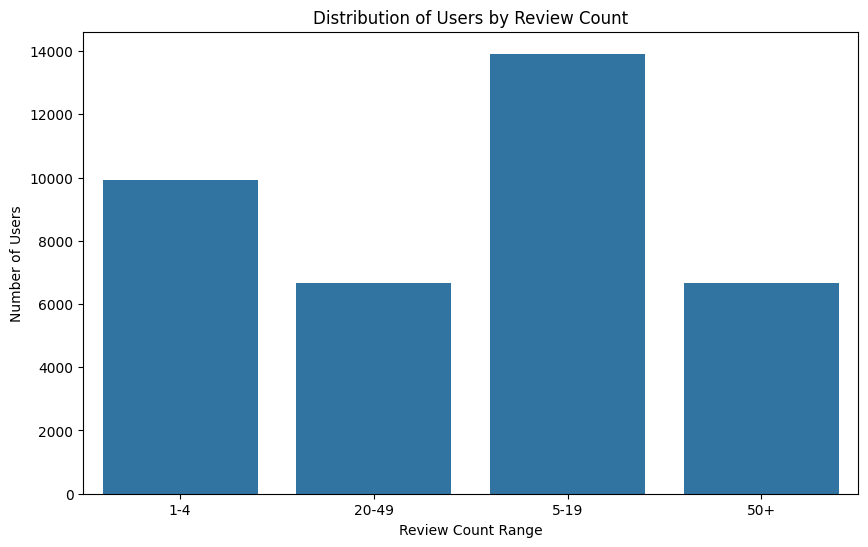

In [6]:
# Visualization for user review distribution
user_review_dist_pd = user_review_distribution.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x='review_count_range', y='count', data=user_review_dist_pd)
plt.title('Distribution of Users by Review Count')
plt.xlabel('Review Count Range')
plt.ylabel('Number of Users')
plt.show()

In [7]:
# 2. Top 10 users with the most fans
top_fan_users = users_df.select("user_id", "name", "fans").orderBy(col("fans").desc()).limit(10)
top_fan_users.show()

+--------------------+----------+----+
|             user_id|      name|fans|
+--------------------+----------+----+
|hizGc5W1tBHPghM5Y...|     Katie|3642|
|JADdo9NEeO5Az9aOY...|Manda Bear|1648|
|nxWrhF_hyX0wwjrEk...|      Ryan|1260|
|f1MFQxTZAWJnRQdro...|      Matt|1082|
|dIIKEfOgo0KqUfGQv...|      Gabi|1062|
|chhv5egoLSXHs4my1...|  Margaret|1054|
|w-w-k-QXosIKQ8HQV...|   Anthony|1021|
|NrSURtBigpxbdfL4n...|     Missy|1003|
|om5ZiponkpRqUNa3p...|    Andrea|1002|
|7IV3JXTXufasWNSkD...|  Benjamin| 934|
+--------------------+----------+----+



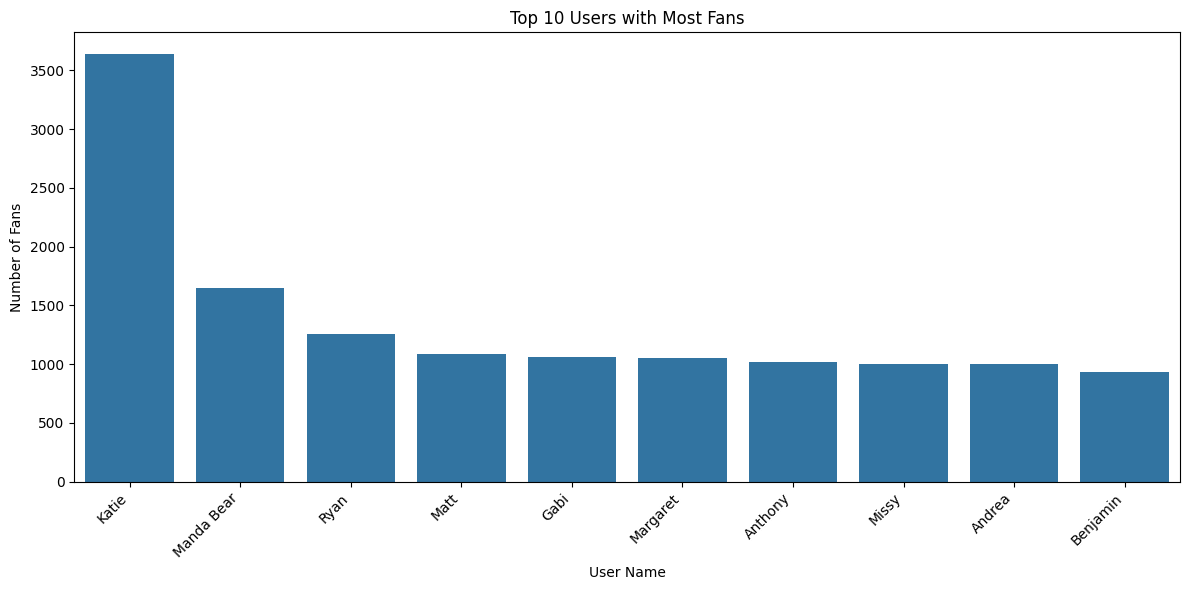

In [8]:
# Visualization for top 10 users with most fans
top_fan_users_pd = top_fan_users.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='fans', data=top_fan_users_pd)
plt.title('Top 10 Users with Most Fans')
plt.xlabel('User Name')
plt.ylabel('Number of Fans')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
# 3. Average stars given by elite vs non-elite users
from pyspark.sql.functions import when, col, avg, length

# First, let's check the distribution of elite and non-elite users
user_distribution = users_df.select(
    when(length(col("elite")) > 0, "Elite")
    .otherwise("Non-Elite")
    .alias("elite_status")
).groupBy("elite_status").count()

user_distribution.show()

+------------+-----+
|elite_status|count|
+------------+-----+
|   Non-Elite|33579|
|       Elite| 3603|
+------------+-----+



In [10]:
elite_vs_nonelite = users_df.withColumn(
    "elite_status", 
    when(length(col("elite")) > 0, "Elite")
    .otherwise("Non-Elite")
).groupBy("elite_status").agg(avg("average_stars").alias("avg_stars_given"))

elite_vs_nonelite.show()

+------------+------------------+
|elite_status|   avg_stars_given|
+------------+------------------+
|   Non-Elite|3.6794582923851147|
|       Elite|3.9906661115736877|
+------------+------------------+



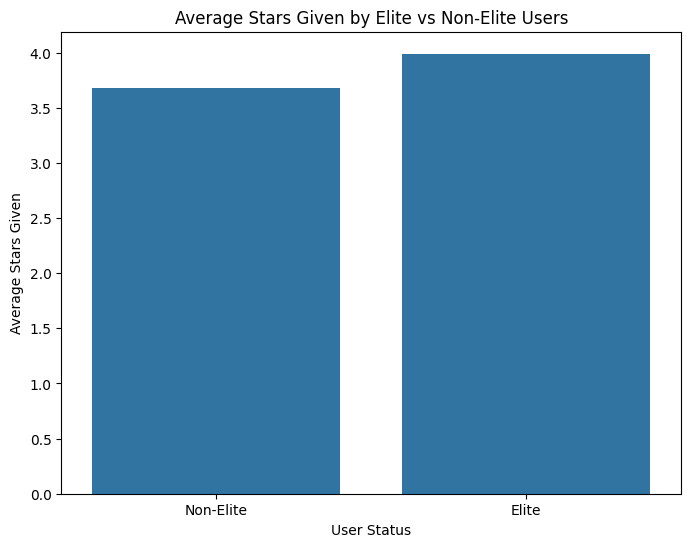

In [11]:
# Visualization for elite vs non-elite users
elite_vs_nonelite_pd = elite_vs_nonelite.toPandas()
plt.figure(figsize=(8, 6))
sns.barplot(x='elite_status', y='avg_stars_given', data=elite_vs_nonelite_pd)
plt.title('Average Stars Given by Elite vs Non-Elite Users')
plt.xlabel('User Status')
plt.ylabel('Average Stars Given')
plt.show()

In [12]:
# 4. Distribution of users by account age
user_account_age = users_df.withColumn(
    "account_age_years", datediff(current_date(), col("yelping_since")) / 365
).groupBy(
    when(col("account_age_years") < 1, "<1 year")
    .when(col("account_age_years") < 3, "1-2 years")
    .when(col("account_age_years") < 5, "3-4 years")
    .otherwise("5+ years").alias("account_age_group")
).count().orderBy("account_age_group")
user_account_age.show()

+-----------------+-----+
|account_age_group|count|
+-----------------+-----+
|        1-2 years|   61|
|        3-4 years| 1201|
|         5+ years|35920|
+-----------------+-----+



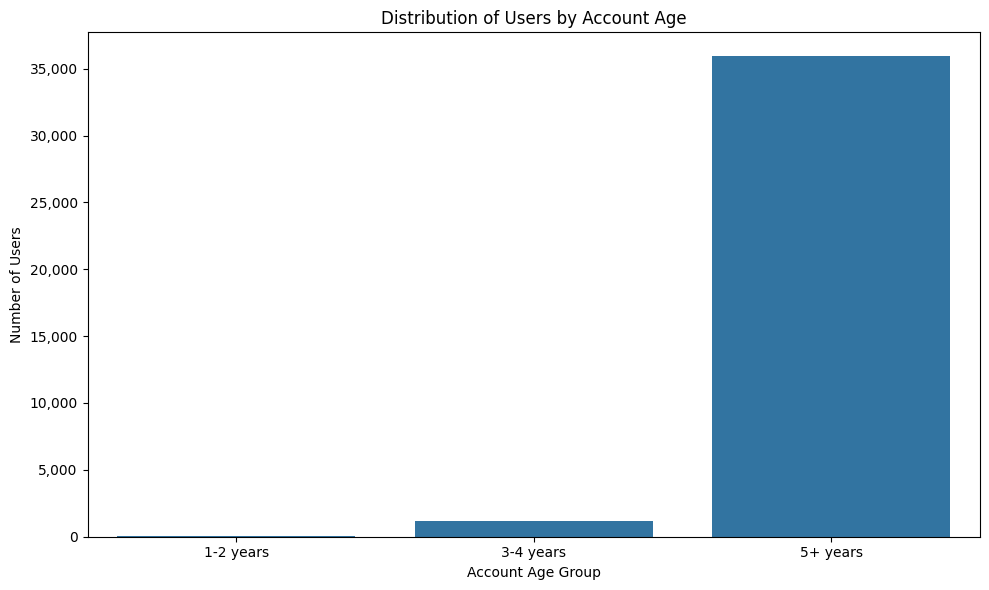

In [13]:
# Visualization for user account age distribution
user_account_age_pd = user_account_age.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x='account_age_group', y='count', data=user_account_age_pd)
plt.title('Distribution of Users by Account Age')
plt.xlabel('Account Age Group')
plt.ylabel('Number of Users')

# Format y-axis labels as integers
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()


In [14]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Define a function to get sentiment score from review text
def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

# Create a UDF (User Defined Function) for sentiment analysis
sentiment_udf = udf(get_sentiment, DoubleType())

# Add a sentiment score column to the user reviews DataFrame
user_reviews_with_sentiment_df = reviews_df.withColumn("sentiment_score", sentiment_udf(reviews_df["text"]))

# Show the first few rows with sentiment scores
user_reviews_with_sentiment_df.show(5)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dps/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+-----------+-------------+--------------------+-----------+------------+-----+-----+---------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|             address|          attributes|          categories|  city|               hours|is_open|   latitude|    longitude|                name|postal_code|review_count|stars|state|sentiment_score|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+-----------+-------------+--------------------+-----------+------------+-----+-----+---------------+
|UCMSWPqzXjd7

In [15]:
users_df.printSchema()
reviews_df.printSchema()
arizona_businesses_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- yelping_since: string (nullable = true)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (null

In [20]:
# 5. User sentiment analysis by review count
from pyspark.sql.functions import round

# Rename columns before joining to avoid ambiguity
users_df = users_df.withColumnRenamed("name", "user_name") \
    .withColumnRenamed("review_count", "user_review_count")
arizona_businesses_df = arizona_businesses_df.withColumnRenamed("name", "business_name") \
    .withColumnRenamed("review_count", "business_review_count") \
    .withColumnRenamed("categories", "business_categories") \
    .withColumnRenamed("city", "business_city") 
reviews_df = reviews_df.withColumnRenamed("useful", "review_useful") \
    .withColumnRenamed("funny", "review_funny") \
    .withColumnRenamed("cool", "review_cool") \
    .withColumnRenamed("city", "review_city") \
    .withColumnRenamed("stars", "review_stars") \
# Join users and reviews
users_reviews = users_df.join(reviews_df, "user_id")

# Join the result with businesses
full_joined_df = users_reviews.join(arizona_businesses_df, users_reviews.business_id == arizona_businesses_df.business_id)

# Perform sentiment analysis
sentiment_by_review_count = full_joined_df.groupBy(
    when(col("user_review_count") < 10, "Novice")
    .when(col("user_review_count") < 50, "Regular")
    .when(col("user_review_count") < 100, "Veteran")
    .otherwise("Elite").alias("user_category"),
    when(col("elite").isNull(), "Non-Elite").otherwise("Elite").alias("elite_status")
) \
.agg(
    # Calculate average sentiment score
    round(avg(sentiment_udf(col("text"))), 3).alias("avg_sentiment"),
    # Calculate average star rating
    round(avg("stars"), 2).alias("avg_rating"),
    # Count the number of users in each category
    count("user_id").alias("user_count"),
    # Calculate average review count
    round(avg("user_review_count"), 1).alias("avg_review_count")
) \
.orderBy("user_category", "elite_status")

sentiment_by_review_count.show(10)


+-------------+------------+-------------+----------+----------+----------------+
|user_category|elite_status|avg_sentiment|avg_rating|user_count|avg_review_count|
+-------------+------------+-------------+----------+----------+----------------+
|        Elite|       Elite|        0.802|      3.76|     20166|           323.7|
|       Novice|       Elite|         0.56|      3.69|     20188|             4.5|
|      Regular|       Elite|        0.673|      3.75|     27465|            24.0|
|      Veteran|       Elite|        0.745|      3.78|     10078|            71.1|
+-------------+------------+-------------+----------+----------+----------------+



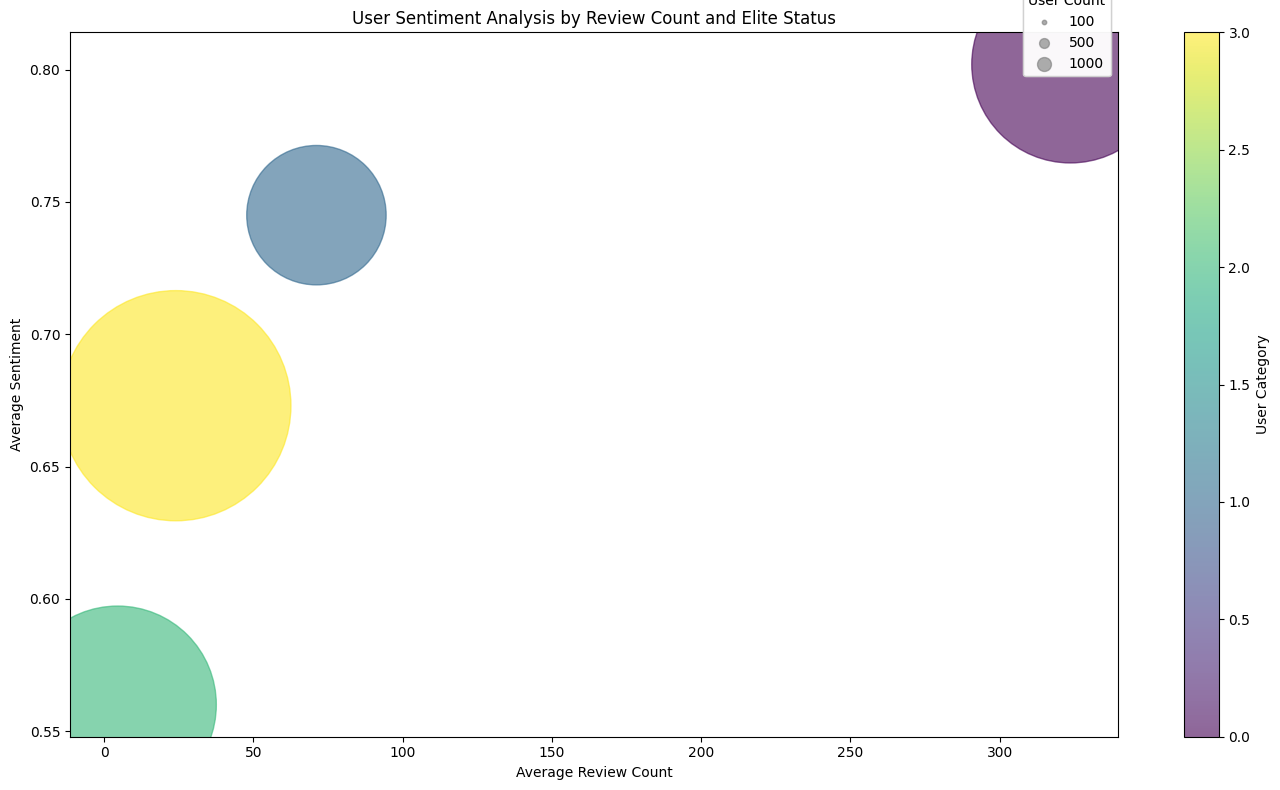

In [30]:
# Visualization for sentiment analysis by review count
# Convert to Pandas DataFrame for visualization
sentiment_analysis_pd = sentiment_analysis.toPandas()

# Create a scatter plot
plt.figure(figsize=(14, 8))
scatter = plt.scatter(sentiment_analysis_pd['avg_review_count'], 
                      sentiment_analysis_pd['avg_sentiment'],
                      c=sentiment_analysis_pd['user_category'].astype('category').cat.codes,
                      s=sentiment_analysis_pd['user_count'],
                      alpha=0.6)

# Add labels and title
plt.xlabel('Average Review Count')
plt.ylabel('Average Sentiment')
plt.title('User Sentiment Analysis by Review Count and Elite Status')

# Add a color bar legend
plt.colorbar(scatter, label='User Category')

# Add a legend for the size of the points
sizes = [100, 500, 1000]
labels = ['100', '500', '1000']
legend1 = plt.legend(handles=[plt.scatter([], [], s=size/10, c='gray', alpha=0.6) for size in sizes],
           labels=labels, title="User Count", loc="center right", bbox_to_anchor=(1, 1))
plt.gca().add_artist(legend1)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [31]:
full_joined_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- review_cool:

In [32]:
# 6. User category preferences and sentiment
from pyspark.sql.functions import explode, split, col, count, avg
category_column = "business_categories"

category_preferences = full_joined_df \
    .withColumn("category", explode(split(col(category_column), ", "))) \
    .groupBy(col("user_id"), col("user_name"), col("category")) \
    .agg(
        count("review_id").alias("category_reviews"),
        avg(sentiment_udf(col("text"))).alias("avg_sentiment")
    ) \
    .orderBy(col("category_reviews").desc())

category_preferences.show(20, truncate=False)

+----------------------+---------+-----------+----------------+------------------+
|user_id               |user_name|category   |category_reviews|avg_sentiment     |
+----------------------+---------+-----------+----------------+------------------+
|W67nXodRWTIa-d1NJlncvA|Saba     |Nightlife  |147             |0.7055224489795919|
|6ObFF8-uKnOAlXuSH4TlyQ|Isabella |Nightlife  |143             |0.9208090909090909|
|6ObFF8-uKnOAlXuSH4TlyQ|Isabella |Bars       |138             |0.9207652173913045|
|W67nXodRWTIa-d1NJlncvA|Saba     |Bars       |136             |0.7344889705882354|
|2YKkLFeOx-0zRcWp0KUv_Q|Mark     |Nightlife  |122             |0.8217221311475409|
|W67nXodRWTIa-d1NJlncvA|Saba     |Restaurants|121             |0.7352743801652893|
|6ObFF8-uKnOAlXuSH4TlyQ|Isabella |Restaurants|116             |0.9178422413793104|
|2YKkLFeOx-0zRcWp0KUv_Q|Mark     |Bars       |116             |0.823468103448276 |
|9Y1YkloHk2MAE3hkwYdFKA|Gene     |Nightlife  |114             |0.8524052631578949|
|2YK

In [39]:
# 7. User review quality and sentiment over time

from pyspark.sql.functions import year, col, avg, count

review_quality_over_time = full_joined_df \
    .withColumn("year", year(col("date"))) \
    .groupBy(col("user_id"), col("user_name"), "year") \
    .agg(
        avg((col("review_useful") + col("review_funny") + col("review_cool")) / 3).alias("avg_quality_score"),
        avg(sentiment_udf(col("text"))).alias("avg_sentiment"),
        count("review_id").alias("review_count")
    ) \
    .orderBy(col("user_id"), "year")

review_quality_over_time.show()

+--------------------+---------+----+------------------+--------------------+------------+
|             user_id|user_name|year| avg_quality_score|       avg_sentiment|review_count|
+--------------------+---------+----+------------------+--------------------+------------+
|--4ZhTMV2fIlGhcUk...|  Belinda|2018|0.3333333333333333|              0.9791|           1|
|--A15Rp8LJspfurcz...|    Jared|2017|               0.0|              0.3912|           1|
|--CIuK7sUpaNzalLA...|  Nomadic|2015|0.3333333333333333|              0.9502|           1|
|--CIuK7sUpaNzalLA...|  Nomadic|2016|               3.0|             -0.0516|           1|
|--U6F4iI3ABK6IVCC...|     Matt|2013|0.3333333333333333|  0.9468000000000001|           2|
|--U6F4iI3ABK6IVCC...|     Matt|2014|               0.0|              0.9042|           1|
|--_N9jPdYR9WdJKQh...|     Sara|2016|2.3333333333333335|-0.02109999999999998|           2|
|--_N9jPdYR9WdJKQh...|     Sara|2017|0.6666666666666666|              0.3818|           1|

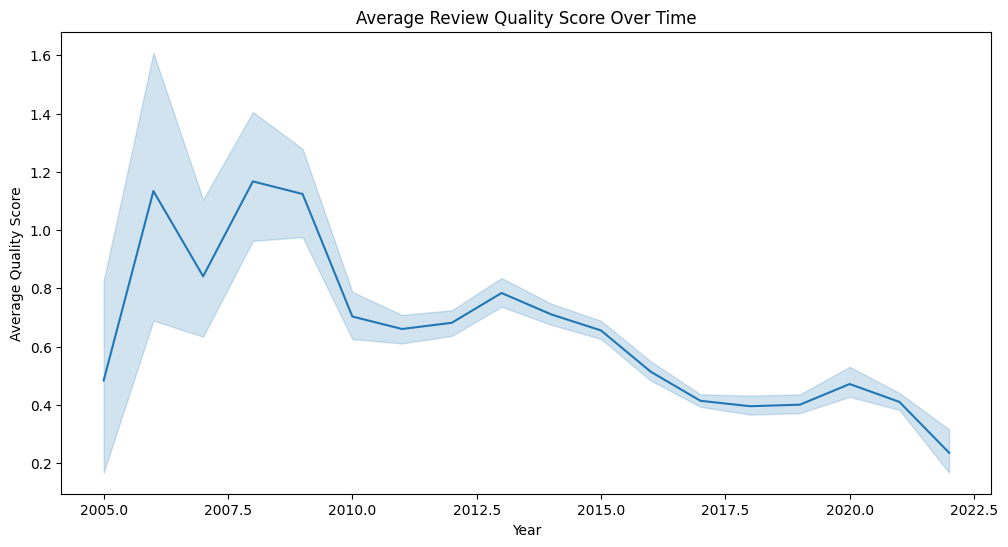

In [41]:
# Visualization for review quality and sentiment over time
review_quality_over_time_pd = review_quality_over_time.toPandas()
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='avg_quality_score', data=review_quality_over_time_pd)
plt.title('Average Review Quality Score Over Time')
plt.xlabel('Year')
plt.ylabel('Average Quality Score')
plt.show()

In [17]:
# 8. User sentiment consistency across reviews per year:

from pyspark.sql.functions import col, avg, stddev, count, year

user_sentiment_consistency = full_joined_df \
    .withColumn("review_year", year(col("date"))) \
    .groupBy("user_id", "user_name", "review_year") \
    .agg(avg(sentiment_udf(col("text"))).alias("avg_year_sentiment")) \
    .groupBy("user_id", "user_name") \
    .agg(
        avg("avg_year_sentiment").alias("overall_avg_sentiment"),
        stddev("avg_year_sentiment").alias("sentiment_stddev"),
        count("review_year").alias("years_active")
    ) \
    .filter(col("years_active") > 1) \
    .orderBy(col("sentiment_stddev").desc())

user_sentiment_consistency.show(10)

+--------------------+---------+---------------------+------------------+------------+
|             user_id|user_name|overall_avg_sentiment|  sentiment_stddev|years_active|
+--------------------+---------+---------------------+------------------+------------+
|4f4P0PvTsPO3fNNpU...|   Alaina| 0.006500000000000006|1.4031826965865848|           2|
|E-DT2EY3-GoFpQphX...|    Maria| -0.00624999999999...|1.4002835587837201|           2|
|wdaB3kTiUoOsD4qCR...|    Robby| 0.007500000000000007|1.3946974152123464|           2|
|RZa0R0k7LYE1-8dUV...|    Paula| 0.002650000000000041| 1.392505384190668|           2|
|e0zd5TlVjqguvhqh5...|Elizabeth| 0.008425000000000016|1.3917629220704222|           2|
|cktPR0gCnQtrfGZms...|      Ann| 0.012350000000000028|1.3891112716409728|           2|
|e8RxiMkK8Mbeq03fU...|     Snuf|               0.0116|1.3846564989194974|           2|
|IdCTNEEcoea5DJAZ_...|   Angela| -0.01460000000000...|1.3812623863698017|           2|
|l-jSesKnq9QjO2Pdq...|      Amy| 0.01169999

In [25]:
# 9. User engagement level and business rating correlation
from pyspark.sql.functions import col, count, avg, ntile, corr
from pyspark.sql.window import Window

engagement_rating_correlation = full_joined_df \
    .groupBy("user_id", "user_name") \
    .agg(count("review_id").alias("review_count"),
         avg("average_stars").alias("avg_user_rating"),
         avg("stars").alias("avg_business_rating")) \
    .withColumn("engagement_level", ntile(5).over(Window.orderBy("review_count"))) \
    .groupBy("engagement_level") \
    .agg(avg("avg_user_rating").alias("avg_user_rating"),
         avg("avg_business_rating").alias("avg_business_rating"),
         corr("avg_user_rating", "avg_business_rating").alias("rating_correlation"))

engagement_rating_correlation.show()

24/11/12 13:38:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 13:38:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 13:38:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 13:38:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 13:39:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 13:39:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 1

+----------------+------------------+-------------------+------------------+
|engagement_level|   avg_user_rating|avg_business_rating|rating_correlation|
+----------------+------------------+-------------------+------------------+
|               1|3.7061341938953922| 3.7490923759580475| 0.259931815990208|
|               2|3.6810609116579407| 3.7238133656044106|0.2349957184565603|
|               3|3.7004410973641755| 3.7214228079612695|0.2577229236160648|
|               4| 3.688368746637974| 3.7093867670790748|0.2503220886502085|
|               5|3.7720736955352274| 3.7448633083004426|0.2659169942757833|
+----------------+------------------+-------------------+------------------+



24/11/12 13:40:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 13:40:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 13:41:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 13:41:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 13:41:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 13:41:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 1

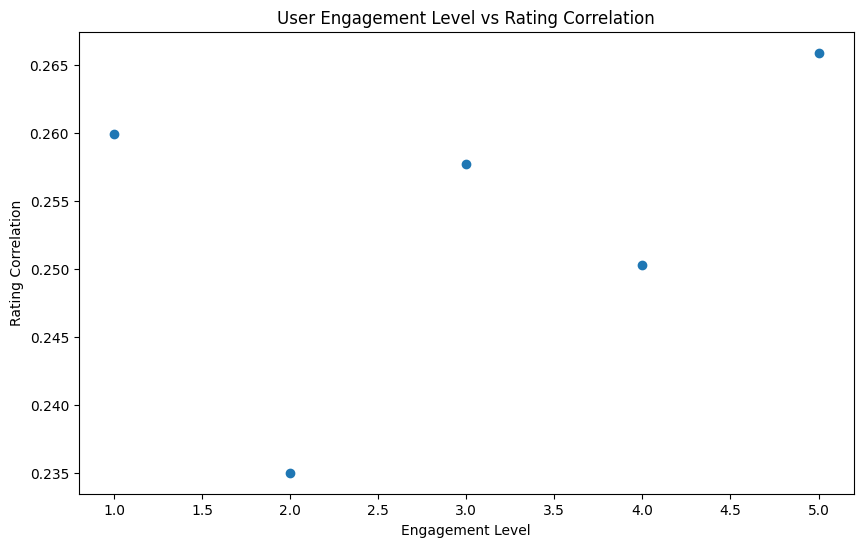

In [26]:
# Visualization for engagement level and business rating correlation
engagement_rating_correlation_pd = engagement_rating_correlation.toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(engagement_rating_correlation_pd['engagement_level'], engagement_rating_correlation_pd['rating_correlation'])
plt.title('User Engagement Level vs Rating Correlation')
plt.xlabel('Engagement Level')
plt.ylabel('Rating Correlation')
plt.show()

In [27]:
# 10. User review length and sentiment analysis by elite status
from pyspark.sql.functions import col, avg, length, when

# User review length and sentiment analysis by elite status
elite_review_analysis = full_joined_df \
    .withColumn("elite_status", when(col("elite").isNull(), "Non-Elite").otherwise("Elite")) \
    .groupBy("user_id", "user_name", "elite_status") \
    .agg(
        avg(length(col("text"))).alias("avg_review_length"),
        avg(sentiment_udf(col("text"))).alias("avg_sentiment"),
        count("review_id").alias("review_count")
    ) \
    .orderBy(col("avg_review_length").desc())

elite_review_analysis.show()

+--------------------+------------+------------+-----------------+-------------+------------+
|             user_id|   user_name|elite_status|avg_review_length|avg_sentiment|review_count|
+--------------------+------------+------------+-----------------+-------------+------------+
|4k3mYMb_G0SKce55y...|      Andrew|       Elite|           5000.0|      -0.9723|           1|
|-_2KmfCxTw9_5vF_x...|           B|       Elite|           4998.0|        0.952|           1|
|KSXc2eJvCujtPxYN1...|laurencechav|       Elite|           4997.0|      -0.9318|           1|
|JYHUNErNpOeFS2OHq...|      Andrew|       Elite|           4988.0|       0.9982|           1|
|abCpn24IYSi5h5Uo0...|        Nate|       Elite|           4985.0|       0.9689|           1|
|-10r3AxaqtewrR2dx...|      Victor|       Elite|           4976.0|       0.9195|           1|
|cgRKSmpD7dEWREKI_...|    Catalina|       Elite|           4961.0|       0.9962|           1|
|4zsNF8VTl0M2g8ikp...|   J Clayton|       Elite|           4

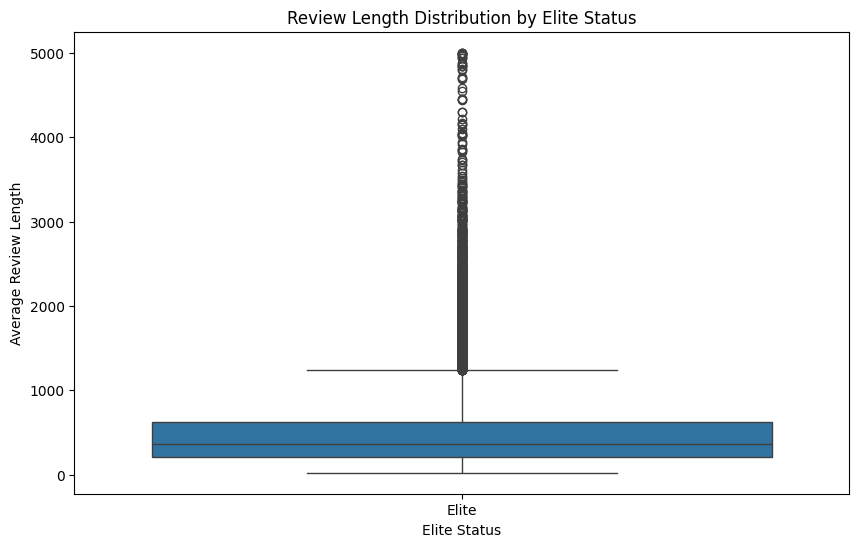

In [28]:
# Visualization for elite review analysis
elite_review_analysis_pd = elite_review_analysis.toPandas()
plt.figure(figsize=(10, 6))
sns.boxplot(x='elite_status', y='avg_review_length', data=elite_review_analysis_pd)
plt.title('Review Length Distribution by Elite Status')
plt.xlabel('Elite Status')
plt.ylabel('Average Review Length')
plt.show()

In [29]:
# Stop the Spark session
spark.stop()